# Recommender System Implementation
To ensure a high quality baseline for our own understanding of recommender systems as well as our comparison, we began our evaluation of recommender systems under a variety of matrix factorization steps for estimating the rating matrix and finished by experimenting on how we can introduce hybrid filtering techniques in our recommendations. For our matrix factorization methods we implemented gradient descent, alternating least squares and the generalization of matrix factorization as released in 2010, factorization machines. Factorization machines were only discussed mathematically and implemented with a framework in order to avoid compute issues, fastFM.

In [ ]:
sys.path.append('/home/jovyan/work')
news = pd.read_csv("../MIND_large/csv/news.csv")
import pandas as pd
import matrix_modules
import sys


## Utilizing clustering
Under gradient descent and alternating least squares we use an incomplete rating matrix $R$ with row and column dimensions determined by clustering type. Two different types of $R$ were used for our baseline, one using user clustering and the other using item clustering. By setting up $R$ in this way we avoided challenges brought on by the binary nature of our data's ratings by increasing the maximum score a rating can achieve.

### Ratings calculations for Item and User Clusters
The ratings for user $u_i$ in an item cluster $IC$ is denoted as $IC_i$ and is calculated as the sum of all interactions that user $u_i$ had with various items in the cluster. Mathematically, it can be expressed as:
$$
IC_{i} = \sum_{j=1}^{n} I_{ij}
$$
The ratings for item $v_{j}$ in a user cluster $UC$ is denoted as $UC_{j}$ and is calculated as the sum of all interactions that users in the cluster had with item $v_{j}$. Mathematically, it can be expressed as:
$$
UC_{j} = \sum_{i=1}^{m} I_{ij}
$$

Under both user and item clustering:
- $n$ or $m$ represent the total number of items in a cluster,
- $I_{ij}$ is a binary indicator defined as follows $ I_{ij} = \begin{cases} 1, & \text{if user } u_{i} \text{ has interacted with item } v_{j} \\ 
0, & \text{otherwise} \end{cases}
$

# Ranking
Ranking is the step where we take our incomplete ratings matrix, $R$, and try to predict the unknown ratings, $\hat{R}$ through two latent factor matrices $U$ and $V$.

For matrix factorization techniques, predicting ratings is formulated as the following non-convex optimization problem which seeks to minimize squared error and use regularization to avoid overfitting:

$$\min_{U,V} \sum_{r_{ij} \text{observed}}{(r_{ij}-u_{i}^Tv_{j})^2} + \lambda(\sum_{i}\|u_i\|^2 + \sum_{j}\|v_j\|^2)$$ 

### Setting Up $U$ and $V$
For our implementations of matrix factorization $U$ and $V$ were both initialized with integers in the range from 0 to 1 from a uniform distribution.

## Gradient Descent
### Introduction
Under gradient descent, we initially found partial derivatives of the aformentioned function with respect to $u_i$ and $v_j$ to acquire update functions for each vector. Using these update functions, each vector in $U$ and $V$ at indices corresponding to observed ratings were updated. With update formulae as shown below:

$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha (r_{ij} -  v_j u_i^T)\cdot v_j - 2\alpha\lambda u_i\\
v_j^{\text{new}} &= v_j + 2\alpha (r_{ij} -  v_j u_i^T)\cdot u_i - 2\alpha\lambda v_j
\end{aligned}
$$

This however proved to be inefficient as our $R$, $U$ and $V$ are still large despite clustering. As an alternative to using the above update functions we instead simplified the process by using two matrices $\Gamma$ and $D$. The matrix $\Gamma$ stored residuals and was found via $R - UV^T$. The binary matrix $D$ kept track of indices corresponding to observed ratings and was created during matrix initialization. With $\Gamma$ and $D$ we were able to modify our update functions to those shown below:

$$
\begin{aligned}
U^{\text{new}} &= U + \alpha (\Gamma \circ D)V - \alpha \lambda U\\
V^{\text{new}} &= V + \alpha (\Gamma \circ D)^TU - \alpha \lambda V
\end{aligned}
$$


### Implementation
The implementation of gradient descent for ratings matrix predictions was simple; update $U$ and $V$ with their update functions for a specified number of iterations while keeping track of updates to $U$ and $V$ as well as RMSE.

## Alternating Least Squares
### Introduction
Alternating Least Squares, or ALS, is another method of matrix factorization similar to gradient descent with one key difference; instead of updating by vector, entire matrices $U$ and $V$ alternate as a fixed variable while optimizing the other. Our implementation of ALS was based off of lecture 14 from CME 323: Distributed Algorithms and Optimization, Spring 2015 from Stanford. Under our implementation of ALS from Stanford the user and item matrices $U$ and $V$ both are of dimension $k$ x $n$ and $k$ x $m$ respectively. The complete ratings matrix $R$ is thus estimated via $U^TV$. 

By fixing $U$ we obtain a convex function of $V$ and vice versa. Therefore in ALS we fix and optimize opposite matrices until convergence. Below is the general algorithm as described in the Stanford materials:

* Initialize $k$ x $n$ and $k$ x $m$ matrices $U$ and $V$
* Repeat the the following until convergence
    * For all column vectors $i = 1,... , n$    
    $$ u_i = (\sum_{r_{ij}\in r_{i *}}{v_jv_j^T + \lambda I_k})^{-1} \sum_{r_{ij}\in r_{i *}}{r_{ij}v_{j}}$$

    * For all column vectors $j = 1,... , m$
    $$ v_j = (\sum_{r_{ij}\in r_{* j}}{u_iu_i^T + \lambda I_k})^{-1} \sum_{r_{ij}\in r_{* j}}{r_{ij}u_{i}}$$

To break it down into pieces:
* $\sum_{{r_{ij}\in r_{i *}}} v_jv_j^T$ and $\sum_{r_{ij}\in r_{* j}} u_iu_i^T$ represent the sum of column vectors multiplied by their transpose where the vectors are determined by either the column vectors correspond to items that user $u_i$ has rated in $V$ or the column vectors correspond to the users in $U$ that have rated item $v_j$.
* $\lambda I_k$ represents the addition of a regularization term $\lambda$ to avoid overfitting.
* $\sum_{r_{ij}\in r_{i *}}{r_{ij}v_{j}}$ and $\sum_{r_{ij}\in r_{* j}}{r_{ij}u_{i}}$ represent the scaling of each column feature vector by a rating with indexing handled in the same way as $\sum v_jv_j^T$ and $\sum u_iu_i^T$.


### Implementation 
ALS implementation starts during the creation of the matrix $R$. Since ALS requires us to subset $V$ and $U$ for columns that correspond to items a user has rated or users that have rated an item we used two hash maps to store these indices. Hash maps were populated during matrix initialization to take advantage of already iterating over items that a user has rated. With the matrix created and our maps initialized, we were able to start optimizing with ALS.

For the optimization steps we found that $\sum_{r_{ij}\in r_{i *}}{v_jv_j^T}$ and $\sum_{r_{ij}\in r_{* j}}{u_iu_i^T}$ are the same as $V_jV_j^T$ and $U_iU_i^T$ with $U_i$ and $V_j$ being the subsets of $U$ and $V$ corresponding to observed ratings. For $\sum_{r_{ij}\in r_{i *}}{r_{ij}v_{j}}$ and $\sum_{r_{ij}\in r_{* j}}{r_{ij}u_{i}}$, we found that we could multiply the observed ratings as a row vector by $V_j^T$ or $U_i^T$ and get the same result as taking the sum. To introduce regularization we added $\lambda I_k$  to $U_iU_i^T$ and $V_iV_i^T$ where $I_k$ is the $k$ x $k$ identity matrix.

Our final update functions for our matrices thus looked like:

$ u_i = ({V_jV_j^T + \lambda I_k})^{-1} {R_{i*}V_{j}^T}$


$ v_j = ({U_iU_i^T + \lambda I_k})^{-1} {R_{*j}U_{i}^T}$

## Factorization Machines
### Introduction
Introduced in 2010, factorization machines offered a generalization of matrix factorization methods. Factorization machines capture all single and pairwise interactions between variables with a closed model equation computable in linear time which proves to be very effective. Equally as advantageous is it allows for the usage of gradient descent to learn model parameters. 

Factorization machines utilize high-dimensional feature vectors along with a feature matrix denoted as $V$. Per the introductory paper on factorization machines a degree two factorization machine has the following equation:

$$ \hat{y}(x) := w_0 + \sum_{i=1}^{n}{w_i x_i} + \sum_{i=1}^{n}\sum_{j=i+1}^{n} \langle \bold{v}_i, \bold{v}_j\rangle x_i x_j$$

The above can be interepreted as follows: 
* $\hat{y}(x)$ represents a predicted rating for a high dimensional feature vector $x$.
* $w_0$ represents global bias.
* $w$ represents a row vector containing feature weights.
* $w_ix_i$ is the weight of the $i$'th feature scaled by that features score in $x$, $x_i$.
* $\langle \bold{v}_i, \bold{v}_j\rangle x_ix_j$ represents a pairwise feature interaction between rows $i$ and $j$ in the feature matrix $V$ scaled by the corresponding scores in the feature vector $x_i$ and $x_j$.

The model parameters that are estimated by gradient descent include $w_0$, $w$ and $V$. 

### Gradient Descent for Factorization Machines
As mentioned earlier, model parameters $w_0$, $w$ and $V$ can all be learned via gradient descent methods on a variety of losses. To get a deeper understanding of how gradient descent can be applied to different optimization problems below we include the gradient vector as discussed in factorization machines introductory paper and associated update formulae.

$$\frac{\partial}{\partial\theta}\hat{y}(x) = \begin{cases} 1, & \text{if } \theta \text{ is } w_0 \\ x_i, & \text{if } \theta \text{ is } w_i \\ x_i\sum_{j=1}^{n}{v_{j,f}}x_j - v_{i,f}x_i^2, & \text{if } \theta \text{ is } v_{i,f} \end{cases} $$

Given the gradient vector we create the following update formulae: 

$w_0^{new} = w_0 + \alpha2(y - \hat{y})$

$w_i^{new} = w_i + \alpha2(y - \hat{y}) * x_i $

$v_{i,f}^{new} = v_{i,f} + \alpha2(y - \hat{y}) * x_i\sum_{j=1}^{n}{v_{j,f}}x_j - v_{i,f}x_i^2$

### Implementation

Instead of fully implementing factorization machines with Numpy we used a factorization machine framework, fastFM. With fastFM, we were able to avoid any computational issues we may have faced while still testing the effectiveness of factorization machines in the context of MIND.

## Model Evaluation
Our testing of gradient descent and alternating least squares focused on the effectiveness of increased latent factors $k$ and how different levels of regularization could affect outcomes. More specifically, both methods were tested on user and item clustering matrices $R$ for values of $k$ equal to 5, 25 and 50 and $\lambda$ equal to 1 and 5. Gradient descent we ran for 100 iterations and ALS we ran for 10 due to the computational efficiency of both being so drastic. Additionally we attempted to see if different initial values of $U$ and $V$ would have an affect on overall quality for gradient descent.

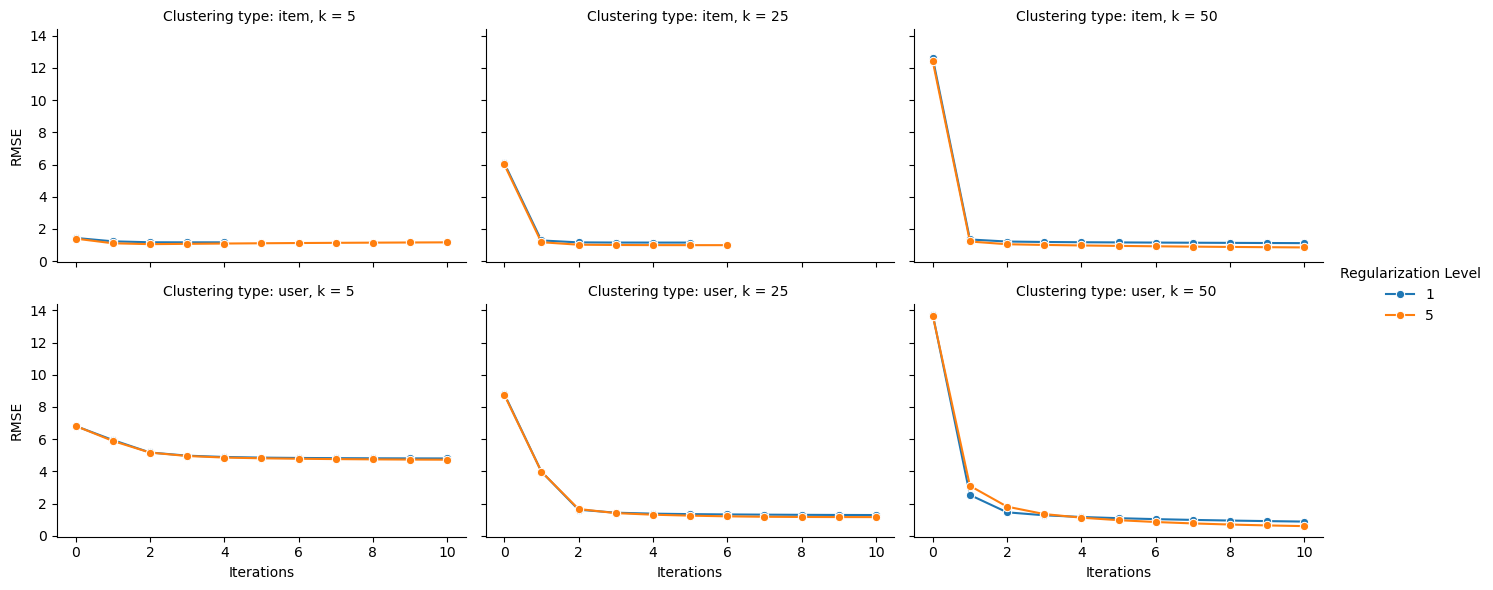

In [2]:
matrix_modules.plot_model_output()

### Interpreting ALS Results
Above we showcase the effects that different values of k and lambda have on each clustering type for ALS. Clearly noticeable is that initial RMSE is positively correlated with the number of latent factors, despite this however for larger numbers of latent factors we receive the lowest RMSE. Additionally, both values of lambda do not have much difference in their effects with lambda of 5 providing the best results. Curiously for clustered users and 5 latent factors ALS converges to an RMSE of around 5. We hypothesize that this may be a result of the algorithm getting stuck in a local minimum. To test this we evaluated different initial values of $V$ and $U$.

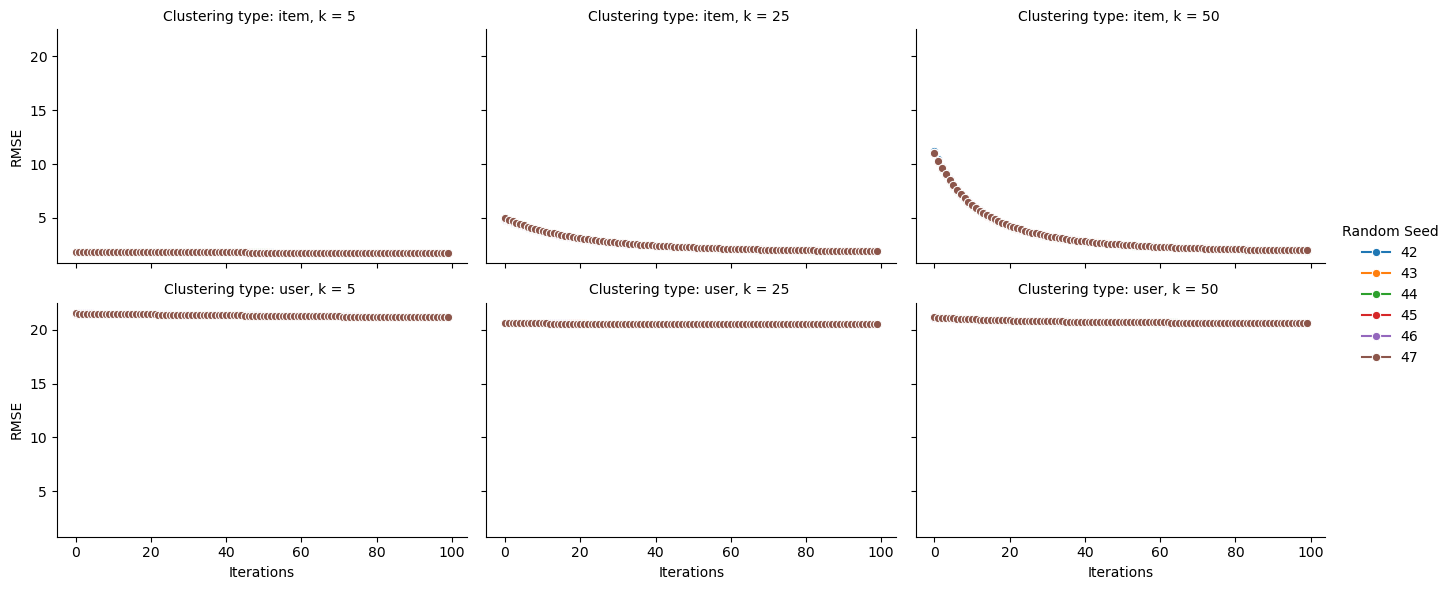

In [3]:
matrix_modules.plot_model_output(False)

### Interpreting Gradient Descent Results
Above we showcase the effects that different initial values of $U$ and $V$ had as well as different values of k. Interestingly regardless of the initial seed for $U$ and $V$ all iterations had very similar results. Under user clustering it appears as though gradient descent got stuck at a high initial RMSE. We hypothesize that this could be due to issues relating to numerical instability brought on by clustering or the algorithm getting stuck in a local minimum.

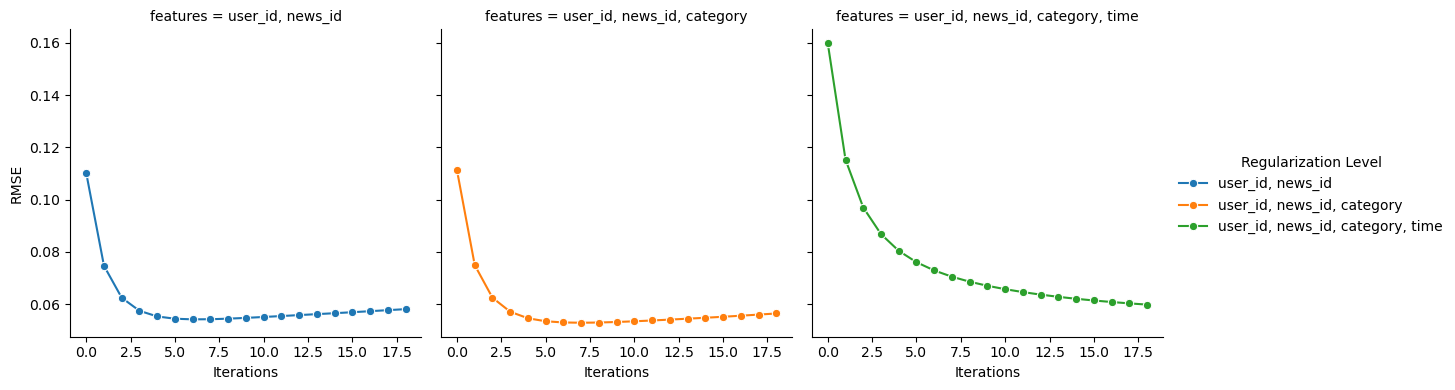

In [57]:
matrix_modules.showcase_fm_results()

### Factorization Machines
Factorization machines were evaluated on an increasing number of features. Starting off with just user and news ids, then adding on category and eventually time. Above we plot the  

Regarding factorization machines we avoid anything further as we wanted to focus on our own implementations which we thought to be more beneficial to our learning.


### An Overview of Predicting R with Matrices 

<img src="https://github.com/jambory/135FinalProject/blob/main/images/ratings.png?raw=true" style="height:500px"/>

# Making Recommendations

Arguably the other most important part of a recommender is the other largest sub-system which takes action on predicted ratings to make recommendations. What's considered a 'good' recommendation differs greatly depending on the goals in place for the recommender system as a whole. For example, if there are business incentives to promote articles of a certain category then 'good' recommendations are ones that a user will interact with and that further business goals. To ensure that our evaluation was comprehensive, we created a basic system to make recommendations on which we improved upon.

### A Simple Way To Recommend Items
For matrix factorization methods like gradient descent and alternating least squares, the most simple form of retrieval is to look at the highest n ratings present in a row of $\hat{R}$. This way of providing recommendations while computationally efficient is prone to providing recommendations of previously viewed items to users lowering the overall quality of recommendations made. 

### Improving Recommendations
We improved the quality of recommendations through the utilization of hybrid filtering and a weighting system. Starting with how hybrid filtering was introduced, user and item features were placed in k-nearest neighbors models to find similar users and their rated items as well as similar items. These items were concatenated together and those that had already been viewed were filtered out. Moving on to the weighting system, weights for each item were determined by the dot product of a users feature vector with the corresponding items feature vector. Weights were then applied to predicted ratings and the top N weighted predictions were served. By making recommendations this way we also made it easier to influence category frequency improving our ability to make recommendations with specific business goals in mind. More specifically, by applying a weight to a category's column in the user and item feature datasets we could ensure that it will be more present in recommendations. 

In [4]:
# Read in features and prepare them for recommendations.
users_df = pd.read_csv("../MIND_large/csv/user_features.csv", index_col=0)
items_df = pd.read_csv("../MIND_large/csv/item_features.csv", index_col=0).drop(columns=[ "travel.1"])
user_features = users_df.copy()
item_features = items_df.copy()
user_features, item_features, user_features_knn, item_features_knn = matrix_modules.prepare_features(user_features, item_features, 'item', 5)

In [6]:
# Run gradient descent and get the top recommendations.
U, V, item_idx, user_idx, full_ratings = matrix_modules.get_predicted("item", 'gd', 25, 5)
seen = {user_id : set(ratings) for user_id, ratings in user_idx.items()}
R_hat = U @ V.T
top_recommendations = matrix_modules.recommend_items(R_hat, seen, 1, full_ratings, user_features, item_features, user_features_knn, item_features_knn, n=4)
examples = matrix_modules.get_items(top_recommendations, item_features, items_df, news, True)

Loading in Data
Creating Matrix
Starting gd iterations


Running Optimized Gradient Descent: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


In [8]:
examples

{'Items from cluster number 37': {'IDs': ['N115210',
   'N67382',
   'N66514',
   'N12308'],
  'Titles': ['The Drive: Can Michael Dickson fulfill the hype?',
   'Seahawks fear OL Justin Britt suffered torn ACL',
   'WATCH: Gardner Minshew finds WR DJ Chark for third touchdown of the day',
   "Bengals notebook: Cordy Glenn's return, Carlos Dunlap 'day to day'"]},
 'Items from cluster number 31': {'IDs': ['N129080',
   'N52012',
   'N102557',
   'N120970'],
  'Titles': ['Body cam video shows the moments before an officer shoots a woman inside her home',
   "Suspect takes off on foot after car chase turned crash on Cleveland's east side",
   'Man killed in officer-involved shooting in St. Louis',
   'Ahad Israfil, gunshot wound survivor, dies']},
 'Items from cluster number 54': {'IDs': ['N58373',
   'N59956',
   'N12017',
   'N78529'],
  'Titles': ["ASK IRA: What's the next Heat step for Kendrick Nunn?",
   'Locked On Suns Wednesday: Suns blast Kings to begin 2019-20 season',
   "Clevela

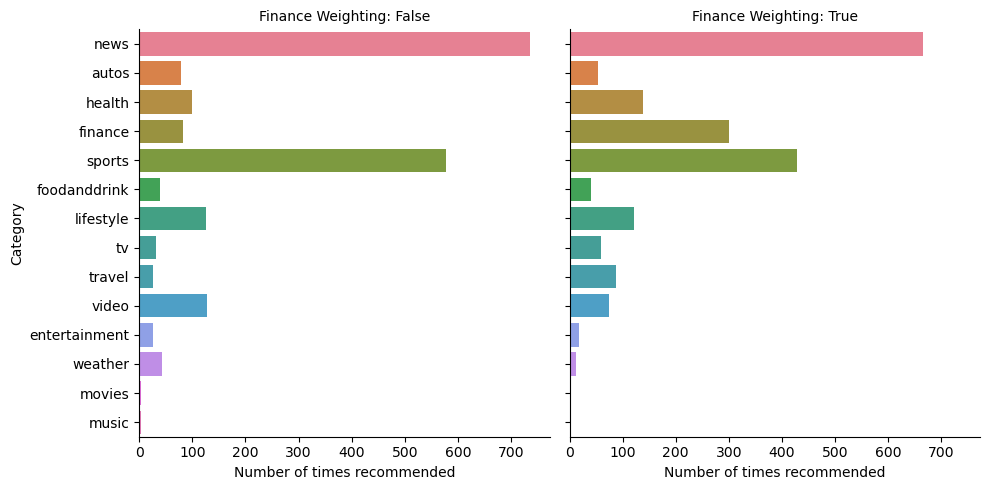

In [7]:
matrix_modules.plot_weight_results()

### Overview of Making Recommendations

<img src="https://github.com/jambory/135FinalProject/blob/main/images/reccomendations.png?raw=true" style="height:500px"/>